# Spectral Permutation Demo
---

## Importing Packages

In [1]:
import numpy as np
import pandas as pd
from src.mheatmap import (
    amc_postprocess, 
    spectral_permute, 
    mosaic_heatmap
)
import matplotlib.pyplot as plt
import scipy

## Load Data

- Load the ground truth labels
    - `Salinas_gt.mat`: Ground truth labels for [Salinas dataset](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes)
- Load the predicted labels from `spectral clustering`

In [2]:
# Load the data
y_true = scipy.io.loadmat("data/Salinas_gt.mat")["salinas_gt"].reshape(-1)
# Load predicted labels from spectral clustering
y_pred = np.array(
    pd.read_csv(
        "data/Salinas_spectralclustering.csv",
        header=None,
        low_memory=False,
    )
    .values[1:]
    .flatten()
)
print(f"y_true shape: {y_true.shape}")
print(f"y_pred shape: {len(y_pred)}")

y_true shape: (111104,)
y_pred shape: 111104


## AMC Post-processing

- Alignment with `Hungarian` algorithm
- Masking the zeros (unlabeled pixels) with [mask_zeros_from_gt](../api/amc-postprocess#mask_zeros_from_gt)
- Computing the confusion matrix

See [AMC Post-processing](../api/amc-postprocess) for more details.

In [3]:
# AMC post-processing
_, conf_mat, labels = amc_postprocess(y_pred, y_true)

## Spectral Permutation

- Treat the confusion matrix as an adjacency matrix
$$
A = C
$$
- Compute the graph Laplacian
$$
L = D - A
$$
- Compute the eigenvectors and eigenvalues
$$
L = U \Sigma U^T
$$
- Sort the eigenvectors based on the eigenvalues
$$
U = [u_1, u_2, \ldots, u_n]
$$
- Fiedler vector is the second smallest eigenvector
$$
f = u_2
$$
- Sort the labels based on the Fiedler vector
$$
\pi\tilde{y} = \tilde{y}[f]
$$
- Reorder the confusion matrix based on the sorted labels
$$
\pi C = C[f, f]
$$

In [4]:
# spectral reordering
reordered_mat, reordered_labels = spectral_permute(conf_mat, labels)

## Visualize the Results

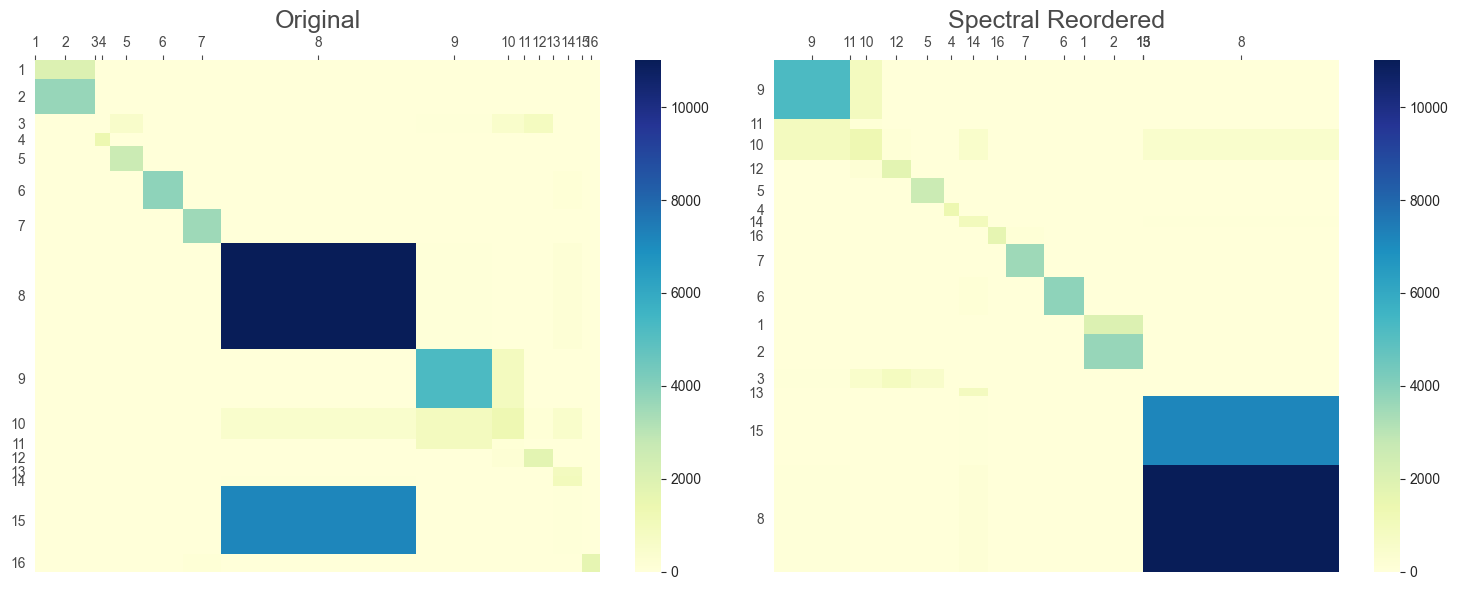

In [5]:
# Visualize original vs spectrally reordered matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

mosaic_heatmap(conf_mat, ax=ax1, xticklabels=labels, yticklabels=labels, cmap="YlGnBu")
ax1.set_title("Original", fontsize=18, color='#4A4A4A')  # Medium gray
ax1.xaxis.set_ticks_position('top')
ax1.tick_params(colors='#4A4A4A')

mosaic_heatmap(
    reordered_mat,
    ax=ax2,
    xticklabels=reordered_labels,
    yticklabels=reordered_labels,
    cmap="YlGnBu",
)
ax2.set_title("Spectral Reordered", fontsize=18, color='#4A4A4A')  # Medium gray
ax2.xaxis.set_ticks_position('top')
ax2.tick_params(colors='#4A4A4A')

plt.tight_layout()
plt.show()